### Mathematical Engineering - Financial Engineering, FY 2024-2025
### Final Project Group 4.A - Credit Migration ,
### Amirreza Khajouei
### Federico Favali

In [1]:
# Importing the libraries

from Data.Data import LoadData, DiscountHandle
from Utilities.Correlation import CorrelationCalibrator, rho_function_Basel
from Utilities.CreditPortfolioVaR import CreditPortfolioVaR


### Loading and Processing the raw data
We load three datasets: discount curve data from January 31st, 2023 for 2-year bond pricing; the seven-class rating transition matrix for Monte Carlo VaR simulation; and Gupton et al.'s empirical joint migration probabilities from 40-quarter S&P data (A and BBB firms) used to calibrate the asset correlation parameter (ρ) in our single-factor Vasicek model.


In [2]:
discounthandle =  DiscountHandle()
discounts = discounthandle.discounts


discounthandle.print_today()
discounthandle.print_target_df()

data = LoadData()

data.show_transition_matrix()
data.validate_matrices()


Today's date: 2023-02-02 00:00:00
Discount Factors DataFrame:
        Date  Discount_Factor
0 2023-08-02         0.985595
1 2024-02-02         0.968301
2 2024-08-02         0.952602
3 2025-02-03         0.938893

Transition Matrix:
Shape: (7, 8)
        AAA      AA       A     BBB      BB       B     CCC  Default
AAA  0.9005  0.0918  0.0055  0.0005  0.0008  0.0003  0.0005   0.0000
AA   0.0057  0.9006  0.0861  0.0058  0.0006  0.0007  0.0002   0.0002
A    0.0003  0.0196  0.9165  0.0575  0.0037  0.0015  0.0002   0.0007
BBB  0.0001  0.0013  0.0383  0.9096  0.0408  0.0063  0.0014   0.0022
BB   0.0002  0.0004  0.0017  0.0576  0.8450  0.0785  0.0076   0.0089
B    0.0000  0.0003  0.0012  0.0025  0.0621  0.8368  0.0505   0.0465
CCC  0.0000  0.0000  0.0018  0.0027  0.0081  0.1583  0.5140   0.3152
Empirical matrix row sums close to 1.0: True
Transition matrix row sums close to 1.0: True

Row sums:
Empirical matrix:
[0.         0.00149174 0.06198816 0.86373773 0.05829428 0.01001921
 0.00309618 0.0

In [3]:
# Part A: Calibration

# Define methods to test
modes = ['weighted_MSE', 'MSE', 'weighted_MAE', 'MAE', 'likelihood', 'KL', 'JSD']
#modes = ['weighted_MSE', 'KL', 'JSD', 'weighted_MAE']

calibrator = CorrelationCalibrator(data)
calibration_df = calibrator.calibrate_all_methods(modes)
print(calibration_df.to_string(index=False, float_format='%.7f'))


results_df, all_results = calibrator.run_comprehensive_analysis(modes, calibration_df,n_bootstrap=100, confidence_level=0.95)

# Display results
print("\nFinal Results:")
print("=" * 80)
print(results_df.to_string(index=False, float_format='%.7f'))


      Method  Calibrated_Rho  Loss_Value
weighted_MSE       0.0150966   0.0000020
         MSE       0.0138342   0.0000003
weighted_MAE       0.0202275   0.0143238
         MAE       0.0177074   0.0018468
  likelihood       0.0070733   0.9319568
          KL       0.0070733   0.0000653
         JSD       0.0071715   0.0000171
--------------------------------------------------

Analysing with weighted_MSE loss function...
Performing bootstrap analysis...
Calibrated rho: 0.015097 with loss: 2.00407924e-06
95.0% Confidence Interval: [0.010010, 0.019801]
Bootstrap std error: 0.002376
Bootstrap p-value: 0.000000
Reject H0 (rho=0) at 95.0% confidence level (p-value method)
--------------------------------------------------

Analysing with MSE loss function...
Performing bootstrap analysis...
Calibrated rho: 0.013834 with loss: 2.78983224e-07
95.0% Confidence Interval: [0.010006, 0.020710]
Bootstrap std error: 0.002428
Bootstrap p-value: 0.000000
Reject H0 (rho=0) at 95.0% confidence level (p

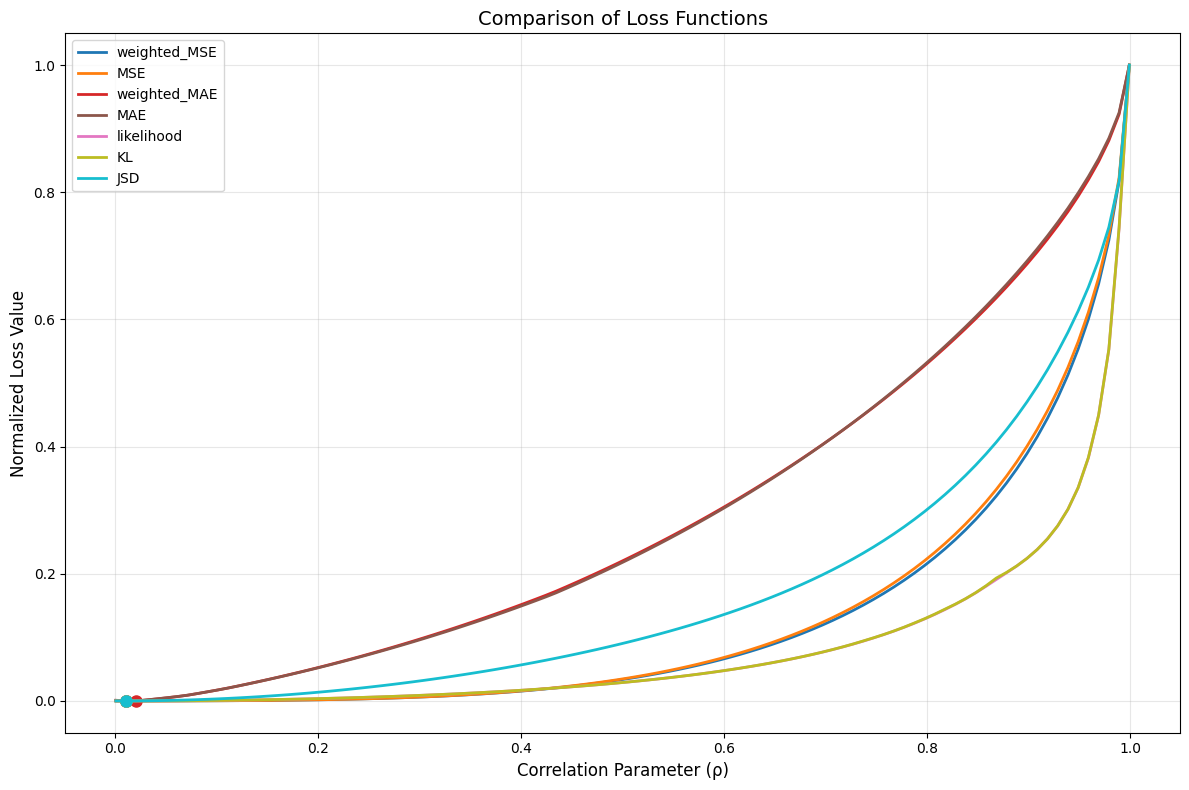

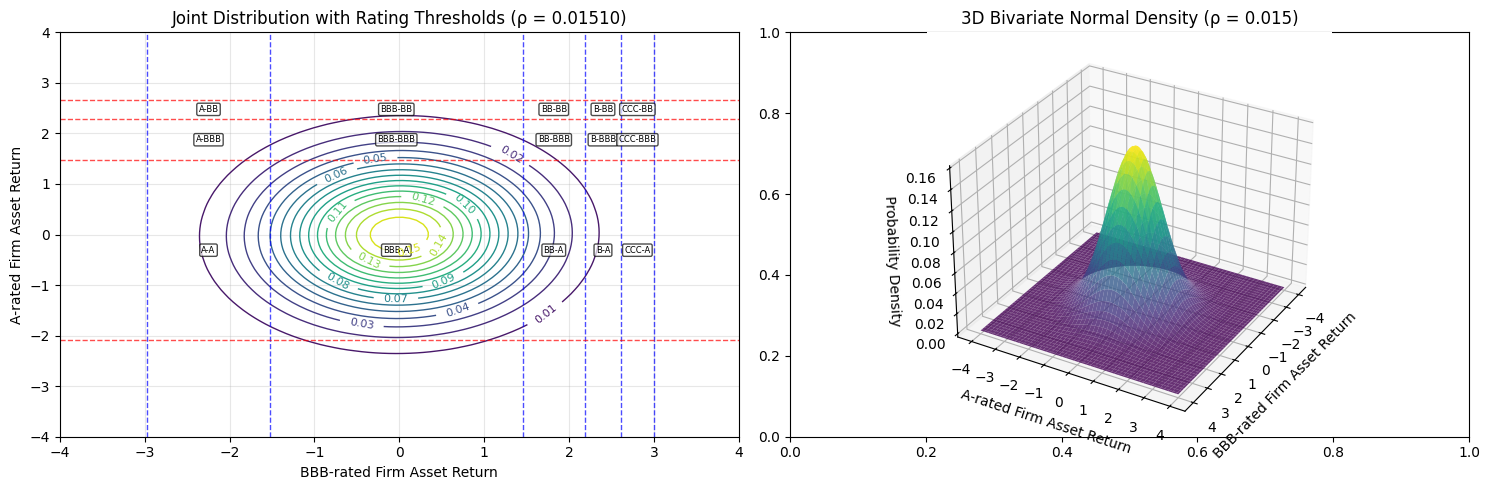

In [4]:
# Part B: Visualization

# Get calibrated rho
calibrated_rho = results_df[results_df['Method'] == 'weighted_MSE']['Calibrated_Rho'].iloc[0]

calibrator.plot_multiple_objective_functions(modes, (0.001, 0.999))
calibrator.visualize_joint_distribution(rho=calibrated_rho, figsize=(15, 5))

In [5]:
# =============================================
# PARAMETERS SETUP
# =============================================
mc_simulations = 1_000_000
confidence_level = 0.999
seed = 37

# Correlation parameters
rho_constant = results_df.loc[results_df["Method"] == "weighted_MSE", "Calibrated_Rho"].values[0]

# Basel II correlations
default_probs = data.get_default_transition_matrix()
rho_basel_A = rho_function_Basel(default_probs.loc["A"])
rho_basel_BBB = rho_function_Basel(default_probs.loc["BBB"])

# Vasicek model initialization
calculator = CreditPortfolioVaR(data, discounts)

data.print_portfolio()
print(f"  - MC simulations: {mc_simulations:,}")
print(f"  - Confidence level: {confidence_level:.1%}")
print("=" * 80)
print(f"Initial Portfolio Mark-to-Market: ${calculator.initial_portfolio_value:,.2f}")



Portfolio Configuration:
  - A-rated bonds: 50
  - BBB-rated bonds: 50
  - Recovery rate: 40.0%
  - Face value: 1
  - MC simulations: 1,000,000
  - Confidence level: 99.9%
Initial Portfolio Mark-to-Market: $93.70


In [6]:
# =============================================
# POINT 2.A: CONSTANT CORRELATION
# =============================================

print("POINT 2.A")
print(f"Using constant correlation ρ = {rho_constant:.3f} for both A and BBB bonds")

results_2a = calculator.simulate_portfolio_var(rhoA=rho_constant,rhoBBB=rho_constant,
    n_simulations=mc_simulations,confidence_level=confidence_level,seed=seed)

calculator.print_results_summary(results_2a)

POINT 2.A
Using constant correlation ρ = 0.015 for both A and BBB bonds

VaR Analysis Results
--------------------
VaR (99.9%):              $     1.24461
Mean portfolio loss:      $     0.00153
VaR as % of portfolio:         1.32834%


In [7]:
# =============================================
# POINT 2.B: BASEL II CORRELATIONS
# =============================================

print("POINT 2.B: VaR with Basel II Rating-Dependent Correlations")
print("-" * 50)
print(f"A-rated correlation: ρ_A = {rho_basel_A:.4f}")
print(f"BBB-rated correlation: ρ_BBB = {rho_basel_BBB:.4f}")

results_2b = calculator.simulate_portfolio_var(rhoA=rho_basel_A,rhoBBB=rho_basel_BBB,
    n_simulations=mc_simulations,confidence_level=confidence_level, seed=seed)

calculator.print_results_summary(results_2b)

POINT 2.B: VaR with Basel II Rating-Dependent Correlations
--------------------------------------------------
A-rated correlation: ρ_A = 0.2359
BBB-rated correlation: ρ_BBB = 0.2275

VaR Analysis Results
--------------------
VaR (99.9%):              $     3.45118
Mean portfolio loss:      $     0.00149
VaR as % of portfolio:         3.68334%


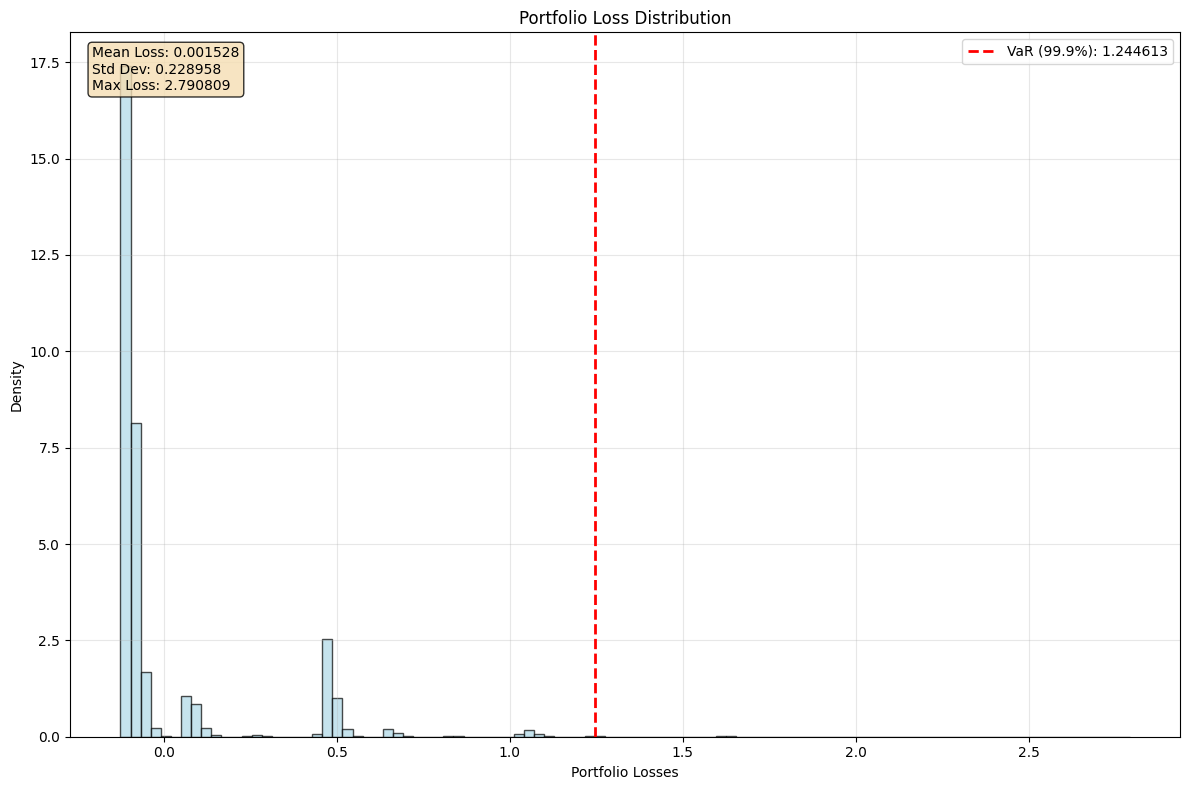

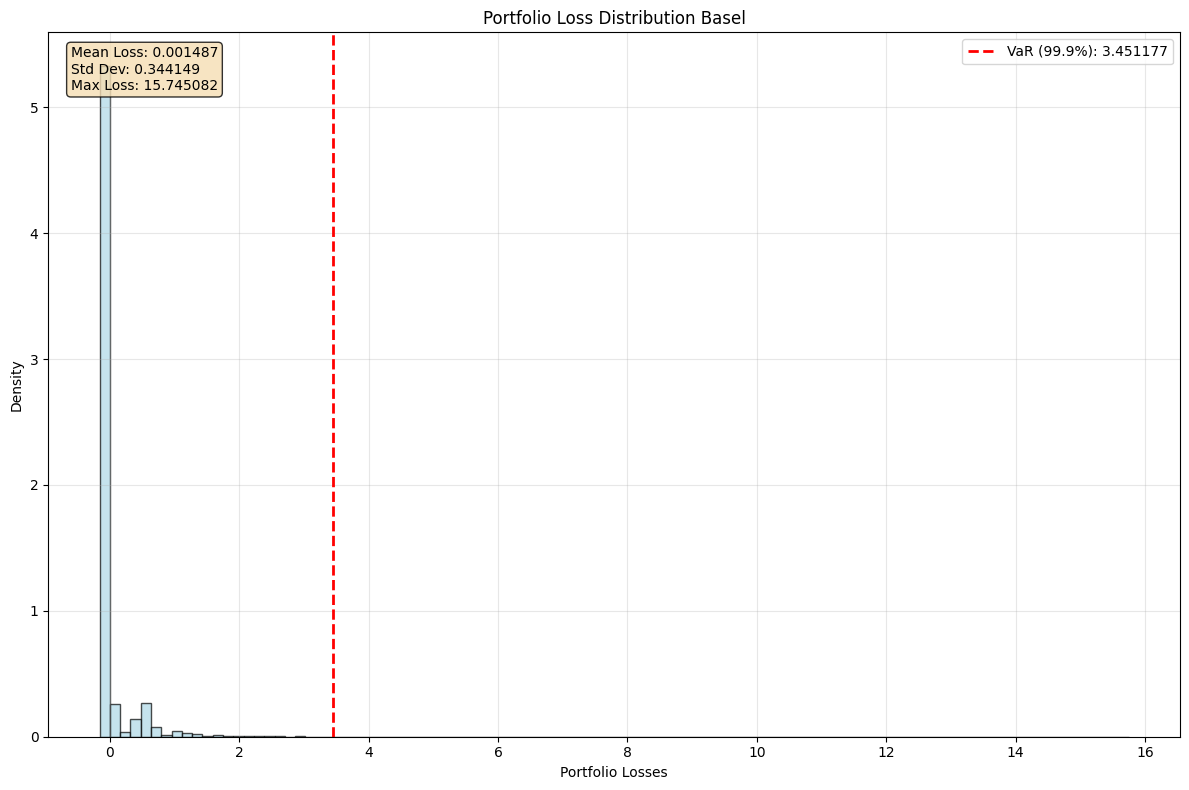

In [8]:
calculator.plot_portfolio_losses(results_2a['portfolio_losses'],results_2a['var'], 0.999, "Portfolio Loss Distribution")
calculator.plot_portfolio_losses(results_2b['portfolio_losses'],results_2b['var'], 0.999,"Portfolio Loss Distribution Basel")